In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    positional_emb = True
    conv_layers = 2
    projection_dim = 128
    early_stopping_patience=5
    num_heads = 2
    transformer_units = [
        projection_dim,
        projection_dim,
    ]
    transformer_layers = 2
    stochastic_depth_rate = 0.1
    
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 50
    image_size = 32
    num_classes = 10
    input_shape = (32, 32, 3)

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow_addons as tfa

/home/ml/anaconda3/envs/ml_tf_torch/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train, CFG.num_classes)
y_test = tf.keras.utils.to_categorical(y_test, CFG.num_classes)

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


# The CCT tokenizer

In [5]:
class CCTTokenizer(tf.keras.layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=CFG.conv_layers,
        num_output_channels=[64, 128],
        positional_emb=CFG.positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                tf.keras.layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(tf.keras.layers.ZeroPadding2D(padding))
            self.conv_model.add(
                tf.keras.layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = tf.keras.layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# Stochastic depth for regularization

In [6]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

# MLP for the Transformers encoder

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

# Data augmentation

In [8]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(scale=1.0 / 255),
        tf.keras.layers.RandomCrop(CFG.image_size, CFG.image_size),
        tf.keras.layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

# The final CCT model

In [9]:
def create_cct_model(
    image_size=CFG.image_size,
    input_shape=CFG.input_shape,
    num_heads=CFG.num_heads,
    projection_dim=CFG.projection_dim,
    transformer_units=CFG.transformer_units,
):

    inputs = tf.keras.layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if CFG.positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, CFG.stochastic_depth_rate, CFG.transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(CFG.transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(tf.keras.layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = tf.keras.layers.Dense(CFG.num_classes)(weighted_representation)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# Model training and evaluation

In [10]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                          factor=0.7,
                                                          min_delta=0.001,
                                                          patience=3,
                                                          mode="auto")
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=CFG.early_stopping_patience,
        restore_best_weights=True,
        min_delta=0.01,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=CFG.batch_size,
        epochs=CFG.num_epochs,
        validation_split=0.1,
        callbacks=[reduceLROnPlat, early_stopping],
    )
    
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/50
352/352 [==============================] - 4s 7ms/step - loss: 1.9102 - accuracy: 0.3341 - top-5-accuracy: 0.8339 - val_loss: 1.6326 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.9308 - lr: 0.0010
Epoch 2/50
352/352 [==============================] - 2s 6ms/step - loss: 1.5596 - accuracy: 0.5043 - top-5-accuracy: 0.9332 - val_loss: 1.4434 - val_accuracy: 0.5520 - val_top-5-accuracy: 0.9542 - lr: 0.0010
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4402 - accuracy: 0.5648 - top-5-accuracy: 0.9506 - val_loss: 1.4012 - val_accuracy: 0.5832 - val_top-5-accuracy: 0.9578 - lr: 0.0010
Epoch 4/50
352/352 [==============================] - 2s 6ms/step - loss: 1.3662 - accuracy: 0.6011 - top-5-accuracy: 0.9592 - val_loss: 1.4026 - val_accuracy: 0.5860 - val_top-5-accuracy: 0.9588 - lr: 0.0010
Epoch 5/50
352/352 [==============================] - 2s 6ms/step - loss: 1.3066 - accuracy: 0.6330 - top-5-accuracy: 0.9655 - val_loss: 1.2632 - val_accuracy: 0.65

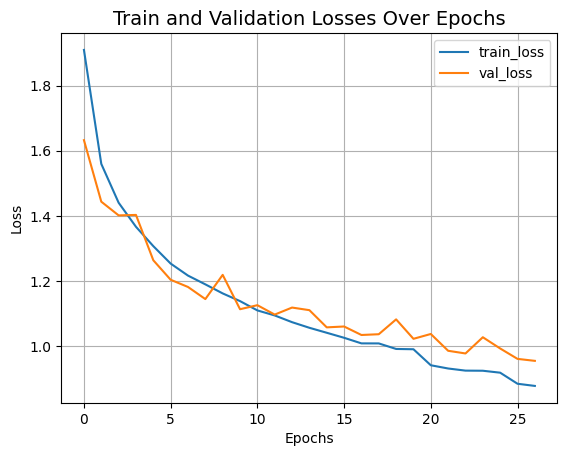

In [11]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [12]:
# Visualization X_test
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

1/1 [==============================] - 0s 14ms/step


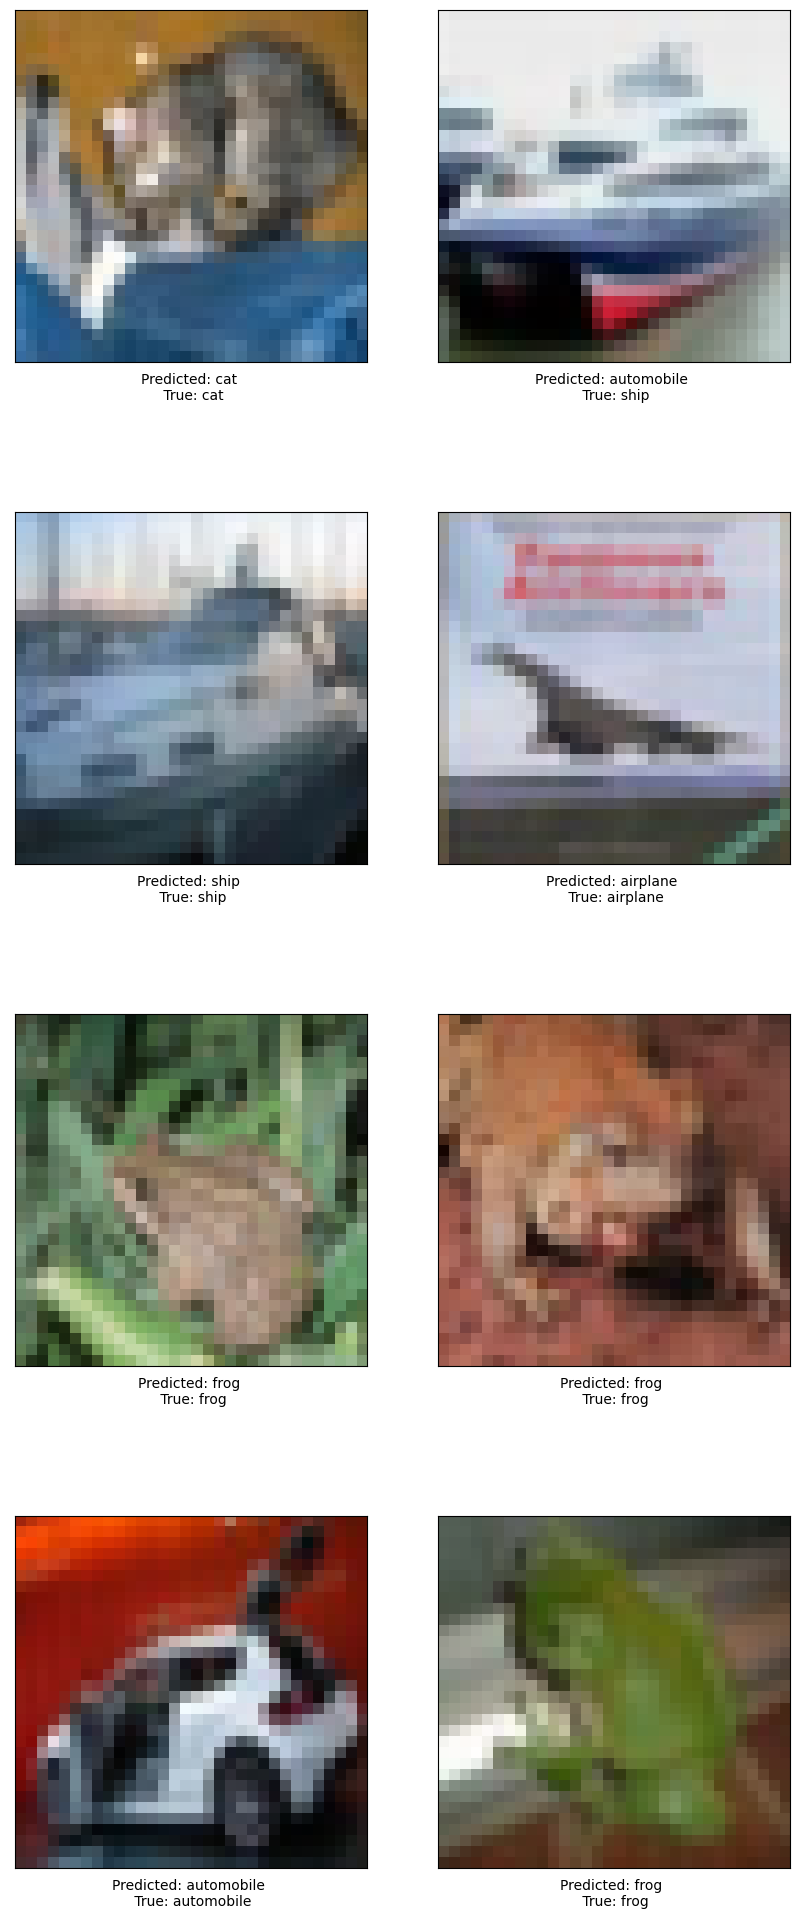

In [13]:
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = y_test[i]



    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[np.argmax(true_label)]}")
plt.show()